In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#File path adn sheet name of raw data file
file_path=r"D:\Workspace\Projects\DS related\customer-churn-analysis-powerbi\prediction_data.xlsx"
sheet_name='vw_ChurnData'

data=pd.read_excel(file_path,sheet_name=sheet_name)
data.head(5)

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,Others,Others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,Others,Others
3,11179-MAH,Male,35,No,Maharashtra,10,12,NaN,Yes,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,Others,Others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,Others,Others


In [12]:
# help(data)
data.columns

Index(['Customer_ID', 'Gender', 'Age', 'Married', 'State',
       'Number_of_Referrals', 'Tenure_in_Months', 'Value_Deal',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type',
       'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
       'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges',
       'Total_Revenue', 'Customer_Status', 'Churn_Category', 'Churn_Reason'],
      dtype='object')

In [13]:
# Data processing
# Drop columsn that wont be used for prediciton

data=data.drop(["Customer_ID","Churn_Category","Churn_Reason"],axis=1)
# Churn_Category and Churn_Reason are directly related to target variable- Customer_Status

# COlumsn to conovert categorical columsn into numerical value:
# To be label encoded
columns_to_encode= ['Gender', 'Married', 'State', 'Value_Deal',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type',
       'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
       'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
       'Payment_Method']

label_encoders={}
for column in columns_to_encode:
    label_encoders[column]=LabelEncoder()
    data[column]=label_encoders[column].fit_transform(data[column])

# manually encode target variable
data["Customer_Status"] = data["Customer_Status"].map({"Stayed":0,"Churned":1})

# Split data into features and target
X = data.drop('Customer_Status',axis=1)
y=data['Customer_Status']

# Split data into training and testing sets:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
# train Random forest model
rf_model=RandomForestClassifier(n_estimators=100,random_state=42) # 100 DTs

rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [18]:
# Evaluating model on test dataset
y_pred=rf_model.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
# [ TN FP], [ FN TP]
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion matrix:
[[795  54]
 [121 232]]
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       849
           1       0.81      0.66      0.73       353

    accuracy                           0.85      1202
   macro avg       0.84      0.80      0.81      1202
weighted avg       0.85      0.85      0.85      1202



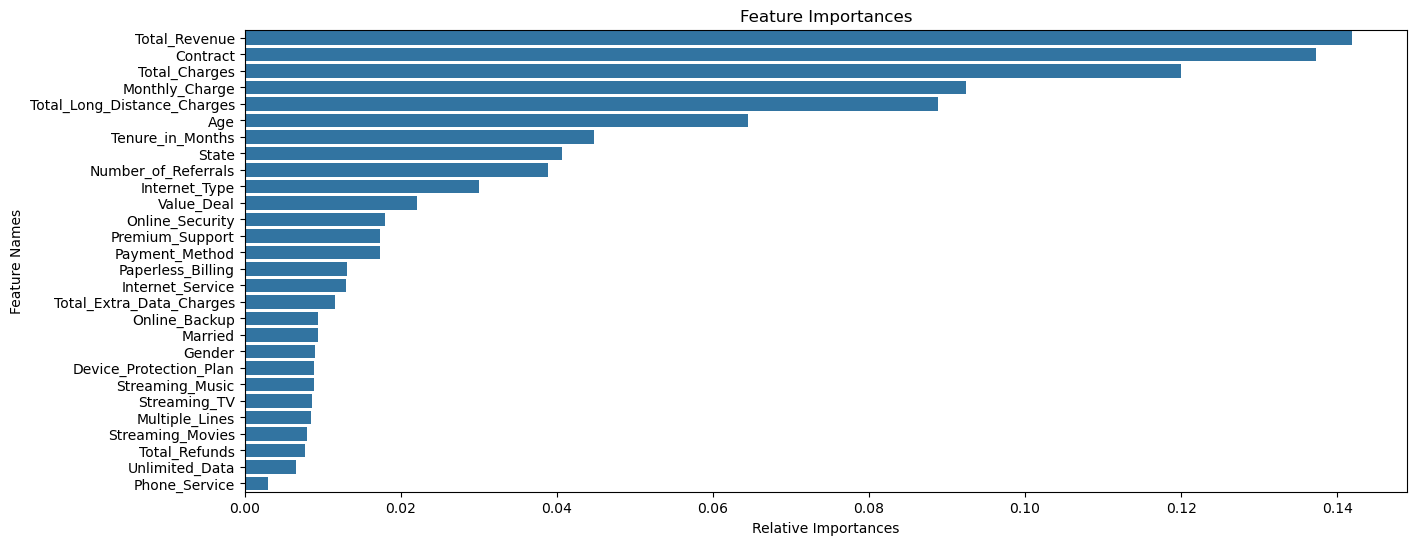

In [23]:
# Feature selection using Feature importance
# Find weightage of each feature in model
importances=rf_model.feature_importances_
indices=np.argsort(importances)[::-1] # Sort reverse

plt.figure(figsize=(15,6))
sns.barplot(x=importances[indices],y=X.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Relative Importances")
plt.ylabel("Feature Names")
plt.show()

In [26]:
# Prediction on new data
file_path=r"D:\Workspace\Projects\DS related\customer-churn-analysis-powerbi\prediction_data.xlsx"
sheet_name='vw_JoinData'

new_data=pd.read_excel(file_path,sheet_name=sheet_name)
new_data.head(5)

new_data.head()

original_data=new_data.copy()

customer_ids=new_data["Customer_ID"]

new_data=new_data.drop(["Customer_ID","Customer_Status","Churn_Category","Churn_Reason"],axis=1)

for column in new_data.select_dtypes(include=["object"]).columns:
    new_data[column]=label_encoders[column].transform(new_data[column])

new_predictions=rf_model.predict(new_data)

original_data["Customer_Status_Predicted"]=new_predictions
original_data=original_data[original_data["Customer_Status_Predicted"]==1]

original_data.to_csv("D:\Workspace\Projects\DS related\customer-churn-analysis-powerbi\predicted_data.xlsx")